In [1]:
import os
import json
import glob
import random

import pandas as pd

from collections import Counter

In [2]:
random.seed(42)

In [3]:
frame_map = json.load(open("../data/raw/mfc_v4.0/codes.json", "r"))

In [68]:
topics = ['climate','deathpenalty','guncontrol','immigration','tobacco','samesex']

In [69]:
all_topics = []
for topic in topics:
    df = pd.read_json(f"../data/raw/mfc_v4.0/{topic}/{topic}_labeled.json").T
    df['topic'] = [topic]*len(df)
    all_topics.append(df)
all_topics_df = pd.concat(all_topics, axis=0)

In [70]:
len(all_topics_df)

44550

In [71]:
all_topics_df['id'] = [i.split("-")[-1] for i in all_topics_df.index.values]

In [72]:
labels = []
for index, row in all_topics_df.iterrows():
    frame_annos = []
    for annotations in row['annotations']['framing'].values():
        frame_annos.extend([str(anno['code']-(anno['code']%1)) for anno in annotations])
    freq_counter = Counter(frame_annos)
    post_labels = [i for i,v in freq_counter.most_common(3)]
    labels.append(post_labels)

In [73]:
all_topics_df['multiple_labels'] = labels

<Axes: ylabel='Frequency'>

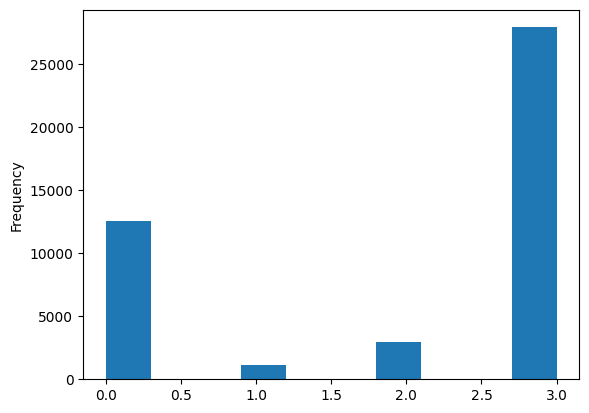

In [74]:
all_topics_df['multiple_labels'].apply(len).plot(kind='hist')

In [75]:
all_topics_df['primary_frame_resolved'] = [str(i)[:-2]+".0" if i is not None else None for i in all_topics_df['primary_frame'].values]

In [76]:
coverage = []
for i, row in all_topics_df.iterrows():
    if row['primary_frame_resolved']:
        if row['primary_frame_resolved'] in row['multiple_labels']:
            # Primary frame in multiple labels
            coverage.append(1)
        else:
            # Primary frame not in multiple labels
            coverage.append(0)
    else:
        # No primary frame
        coverage.append(-1)

In [77]:
# Num examples with primary frame not in majority labels
sum([i == 0 for i in coverage])

144

In [78]:
all_topics_df['clean_text'] = all_topics_df['text'].apply(lambda x: ' '.join(x.split("\n")[3:]))

In [79]:
all_topics_df['multiple_labels_names'] = all_topics_df['multiple_labels'].apply(lambda x: [frame_map[frame_code] for frame_code in x])

In [80]:
len(all_topics_df)

44550

In [81]:
all_topics_df_short = all_topics_df.dropna(subset=['primary_frame'])

In [82]:
len(all_topics_df_short)

31210

In [83]:
all_topics_df[['topic','clean_text','primary_frame_resolved','multiple_labels_names']].to_csv("../data/processed/mfc_multi_label.csv")

Misc comparison

In [84]:
temp_df = pd.read_csv("../data/processed/mfc_consolidated.csv")

In [85]:
print(len(temp_df), len(all_topics_df), len(all_topics_df_short))

31210 44550 31210


In [86]:
all_topics_df = all_topics_df.set_index('clean_text')

In [87]:
mult_labels = []
for i in temp_df.clean_text:
    try:
        mult_labels.append(all_topics_df.loc[i]['multiple_labels'])
    except:
        mult_labels.append(None)

In [88]:
temp_df['multiple_labels'] = mult_labels

In [89]:
all_topics_df_short[['clean_text','topic','multiple_labels']]

,clean_text,topic,multiple_labels
climate_change1.0-1,Too much hot air The White House moved boldl...,climate,"[6.0, 13.0, 1.0]"
climate_change1.0-1000,Education Digest PATTONVILLE SCHOOLS > Textb...,climate,"[1.0, 13.0, 2.0]"
climate_change1.0-10005,The Standoff Between Big Oil and Big Corn A ...,climate,"[1.0, 6.0, 13.0]"
climate_change1.0-10007,"New Study: Burn it All (Fossil Fuel), Lose it...",climate,"[2.0, 14.0]"
climate_change1.0-1001,EPA carbon proposals draw bipartisan Midweste...,climate,"[13.0, 6.0, 2.0]"
...,...,...,...
same-sex_marriage1.0-9987,CLINTON SIGNS SAME-SEX MEASURE< THE BILL BARS...,samesex,"[13.0, 6.0, 4.0]"
same-sex_marriage1.0-9989,President Quietly Signs Law Aimed at Gay Marr...,samesex,"[13.0, 6.0, 12.0]"
same-sex_marriage1.0-9990,CLINTON TO SIGN SAME-SEX MARRIAGE BILL Presi...,samesex,"[13.0, 5.0, 6.0]"
same-sex_marriage1.0-9992,Protest Planned for U-Md. Event; Domestic Par...,samesex,"[12.0, 4.0, 10.0]"


In [90]:
temp_df

,clean_text,label,topic,multiple_labels
0,Too much hot air The White House moved boldl...,Policy Presecription and Evaluation,climate,"[6.0, 13.0, 1.0]"
1,Education Digest PATTONVILLE SCHOOLS > Textb...,Economic,climate,"[1.0, 13.0, 2.0]"
2,The Standoff Between Big Oil and Big Corn A ...,Economic,climate,"[1.0, 6.0, 13.0]"
3,"New Study: Burn it All (Fossil Fuel), Lose it...",Capacity and Resources primany,climate,"[2.0, 14.0]"
4,EPA carbon proposals draw bipartisan Midweste...,Political,climate,"[13.0, 6.0, 2.0]"
...,...,...,...,...
31205,CLINTON SIGNS SAME-SEX MEASURE< THE BILL BARS...,Political,samesex,"[13.0, 6.0, 4.0]"
31206,President Quietly Signs Law Aimed at Gay Marr...,Political,samesex,"[13.0, 6.0, 12.0]"
31207,CLINTON TO SIGN SAME-SEX MARRIAGE BILL Presi...,Political,samesex,"[13.0, 5.0, 6.0]"
31208,Protest Planned for U-Md. Event; Domestic Par...,Public Sentiment,samesex,"[12.0, 4.0, 10.0]"
